In [2]:
!pip install baselines --no-deps

     |████████████████████████████████| 123 kB 7.7 MB/s 
  Created wheel for baselines: filename=baselines-0.1.5-py3-none-any.whl size=163902 sha256=fca21a0561520fe93e081d5afec3621ed3cfb7f44269878daad13dd3722fe050
  Stored in directory: /root/.cache/pip/wheels/64/27/40/3b266f230c825e6b219bfdd5447566d4d109b66fc4e0c074ed
Successfully built baselines


In [3]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!python -m atari_py.import_roms /content/drive/MyDrive/game_ai/roms

copying adventure.bin from ROMS/Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from ROMS/Air Raid (Men-A-Vision) (PAL) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from ROMS/Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/alien.bin
copying amidar.bin from ROMS/Amidar (1982) (Parker Brothers, Ed Temple) (PB5310) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/amidar.bin
copying assault.bin from ROMS/Assault (AKA Sky Alien) (1983) (Bomb - Onbase) (CA281).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/assault.bin
copying asterix.bin from ROMS/Asterix (AKA Taz) (07-27-1983) (Atari, Jerome Domurat, Steve Woita) (CX2696) (Prototype).bin to /usr/local/lib/python3.7/dist-packages/a

In [5]:
from baselines.common.atari_wrappers import make_atari, wrap_deepmind
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



# Configuration paramaters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (epsilon_max - epsilon_min)  # Rate at which to reduce chance of random action being taken
batch_size = 32  # Size of batch taken from replay buffer
max_steps_per_episode = 10000

# Use the Baseline Atari environment because of Deepmind helper functions
env = make_atari("BreakoutNoFrameskip-v4")
# Warp the frames, grey scale, stake four frame and scale to smaller ratio
env = wrap_deepmind(env, frame_stack=True, scale=True)
env.seed(seed)

"""
## Implement the Deep Q-Network
This network learns an approximation of the Q-table, which is a mapping between
the states and actions that an agent will take. For every state we'll have four
actions, that can be taken. The environment provides the state, and the action
is chosen by selecting the larger of the four Q-values predicted in the output layer.
"""

num_actions = 4


def create_q_model():
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(84, 84, 4,))

    # Convolutions on the frames on the screen
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)


# The first model makes the predictions for Q-values which are used to
# make a action.
model = create_q_model()
# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = create_q_model()


"""
## Train
"""

#############################################################################
#IMPROVEMENT 1 (change optimizer Adam to RMSprop)

# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
#optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

#RMSprop optimizer (learning rate of 0.0001 and rho of 0.99)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001, rho=0.99)

#############################################################################


# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0


#############################################################################
#IMPROVEMENT 2 (Remove epsilon_random_frames variable)

# Number of frames to take random action and observe output
#epsilon_random_frames = 50000


# Number of frames for exploration
epsilon_greedy_frames = 1000000.0
#############################################################################




#############################################################################
#IMPROVEMENT 3 (Reduce replay buffer size from 100000 to 10000)

# Maximum replay length
# Note: The Deepmind paper suggests 100000 however this causes memory issues
max_memory_length = 10000
#############################################################################


# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 10000
# Using huber loss for stability
loss_function = keras.losses.Huber()


#############################################################################
#IMPROVEMENT 4 
#(change while loop so training is interrupted after 2000000 frames)

maximum_frames = 1000000

#while True:  # Run until solved

while frame_count < maximum_frames:  # Run until maximum frames
    state = np.array(env.reset())
    episode_reward = 0
#############################################################################
    for timestep in range(1, max_steps_per_episode):
        # env.render(); Adding this line would show the attempts
        # of the agent in a pop up window.
        frame_count += 1


        # Use epsilon-greedy for exploration
        #remove frame_count < epsilon_random_frames
        #as we have removed the variable (epsilon_random_frames) earlier
        #in IMPROVEMENT 2
        #OLD 
        #if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
        #NEW
        if epsilon > np.random.rand(1)[0]:

            # Take random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        #############################################################################
        #IMPROVEMENT 5 
        #( draw a batch and update the Deep Q-Network every 
        #four frames only after the replay buffer is full.)

        # Update every fourth frame and once batch size is over max_memory_length
        #max_memory_length(replay buffer size - 10000)
        if frame_count % update_after_actions == 0 and len(done_history) > max_memory_length:
        ##############################################################################
            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            #########################################################################
            #IMPROVEMENT 7
            #(subsitute two assignment in the baseline implementation
            #by a single assignment shown in listing 2)

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            #updated_q_values = rewards_sample + gamma * tf.reduce_max(
            #   future_rewards, axis=1
            #)

            # If final frame set the last value to -1
            #updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            #Correct implementation: 
            updated_q_values = rewards_sample + (1 - done_sample)*gamma*tf.reduce_max(
                future_rewards, axis=1
            )
            ############################################################################


            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

      
    ##################################################################
    #IMPROVEMENT 6
    #(The variable running reward should still only contain the
    #average return of the last 100 episodes)

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    
    #if len(episode_reward_history) > 100:
        #del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history[-100:])
    ##################################################################
    episode_count += 1

    if running_reward > 40:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break


"""
## Visualizations
Before any training:
![Imgur](https://i.imgur.com/rRxXF4H.gif)
In early stages of training:
![Imgur](https://i.imgur.com/X8ghdpL.gif)
In later stages of training:
![Imgur](https://i.imgur.com/Z1K6qBQ.gif)
"""


###########################################################
# IMPROVEMENT 8 (Save model to Google Drive folder) 

model.save('/content/drive/MyDrive/game_ai/model')


# Also use NumPy to save the list episode_reward_history
# that contains the return for each episode
with open('/content/drive/MyDrive/game_ai/episode_reward_history.txt', 'w') as f:
  np.savetxt(f, episode_reward_history)

###########################################################


running reward: 0.42 at episode 297, frame count 10000
running reward: 0.39 at episode 594, frame count 20000
running reward: 0.27 at episode 876, frame count 30000
running reward: 0.30 at episode 1140, frame count 40000
running reward: 0.21 at episode 1444, frame count 50000
running reward: 0.23 at episode 1754, frame count 60000
running reward: 0.28 at episode 2030, frame count 70000
running reward: 0.27 at episode 2312, frame count 80000
running reward: 0.36 at episode 2616, frame count 90000
running reward: 0.28 at episode 2912, frame count 100000
running reward: 0.28 at episode 3206, frame count 110000
running reward: 0.30 at episode 3512, frame count 120000
running reward: 0.22 at episode 3819, frame count 130000
running reward: 0.27 at episode 4116, frame count 140000
running reward: 0.40 at episode 4399, frame count 150000
running reward: 0.18 at episode 4713, frame count 160000
running reward: 0.31 at episode 5010, frame count 170000
running reward: 0.27 at episode 5299, frame

In [76]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
from baselines.common.atari_wrappers import make_atari, wrap_deepmind
import numpy as np 
import tensorflow as tf 
from tensorflow import keras 
import gym 


def testing(model, env, n_episodes, rewards):
  seed = 42 
  
  model = tf.keras.models.load_model('/content/drive/MyDrive/game_ai/model/saved_model.pb')
  
  env = make_atari("BreakoutNoFrameskip-v4")
  env = wrap_deepmind(env, frame_stack=True, scale=True)
  env.seed(seed)
  
  env = gym.wrappers.Monitor(env,'/content/drive/MyDrive/game_ai/videos', video_callable=lambda episode_id: True, force=True)
  
  n_episodes = 10
  
  rewards = np.zeros(n_episodes, dtype=float)

  for i in range(n_episodes):
        state = np.array(env.reset())
        done = False

        while not done:
            # the action uses greedy policy 
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_values = model.predict(state_tensor)
            action = np.argmax(action_values)
            # to find the action, reward and next state
            state_next, reward, done, _ = env.step(action)
            state = np.array(state_next)
            # rewards is updated
            rewards[i] += reward

 
  return rewards
  env.close()
print('Rewards: {}'. format(rewards))


Rewards: [2. 4. 0. 0. 0. 0. 0. 0. 0. 0.]


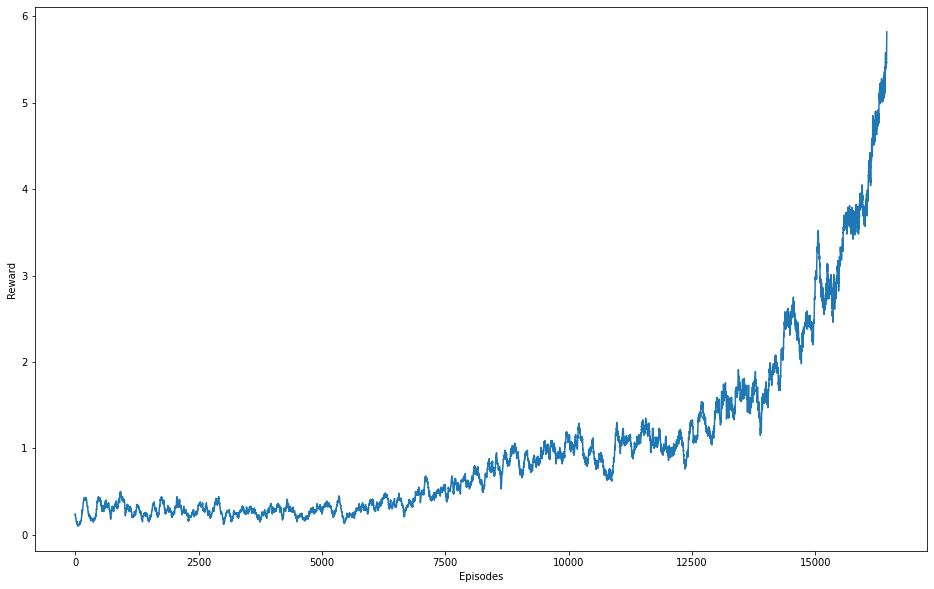

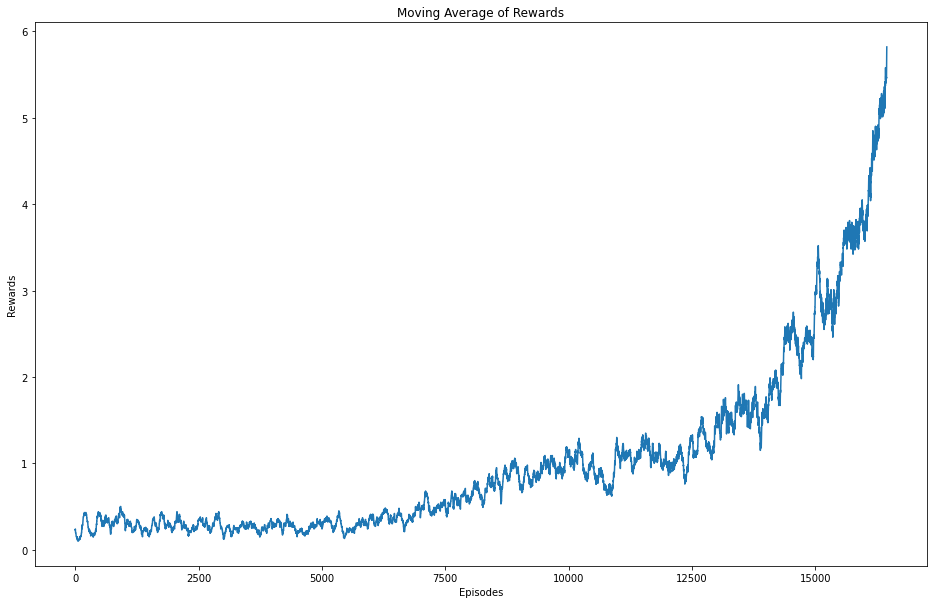

In [89]:
import matplotlib.pyplot as plt

plot_rewards(episode_reward_history)
moving_average_rewards = np.convolve(episode_reward_history, np.ones(100) / 100, mode='valid')

plt.figure(figsize=(16, 10))
plt.plot(moving_average_rewards)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Moving Average of Rewards')
plt.show()